In [342]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorcet as cc
plt.style.use("seaborn")

# 1. Evaluación de cuotas de mercado de suscriptores de televisión fija por departamento

Queremos construir gráficas de evolución temporal de la **cuota de mercado** de los tres principales operadores en los 10 departamentos más representativos (los que tienen más subscriptores). La cuota de mercado se define como la razón del número de suscriptores de un operador  sobre el total de subscriptores. Más adelante discutiremos tendencias, por el momento leamos un archivo reducido de los suscriptores y veamos cómo luce.

In [343]:
dirsuscp="https://raw.githubusercontent.com/caramirezs/DataJam2022/master/bases_datos/suscriptores_tv_dpto_operador.csv"
#dirsuscp="/bases_datos/suscriptores_tv_depto_operador.csv"
tab=pd.read_csv(dirsuscp)
tab.head()

,datetime,id_departamento,departamento,operador,suscriptores
0,2013/01,91,AMAZONAS,TELMEX COLOMBIA S.A.,2475
1,2013/01,91,AMAZONAS,DIRECTV COLOMBIA LTDA,1381
2,2013/01,91,AMAZONAS,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,292
3,2013/01,5,ANTIOQUIA,UNE EPM TELECOMUNICACIONES S.A.,528197
4,2013/01,5,ANTIOQUIA,TELMEX COLOMBIA S.A.,162782


Esta celda evalúa la evolución temporal de la cuota de mercado. Para cada departamento y para cada mes [^1] se seleccionan los tres operadores que dominan el mercado y se calcula su cuota de mercado. Se tuvo especial atención cuando se disponía menos de tres operadores en total.

[^1]: A partir de enero de 2013 por razones de completez de datos

In [344]:
dates=list(tab.datetime.unique()) #Todas las fechas distintas
deptos=list(tab.departamento.unique()) #Todos los departamentos distintos
cnms=["datetime","depto","op1","op2","op3","prop1","prop2","prop3","prop4","total"] #Las columnas de la tabla de datos que se quiere construir. Tres operadores líderes, sus cuotas como proporrciones y el total de suscriptores
suscprop = pd.DataFrame(columns = cnms)
for fecha in dates:
    for dept in deptos:
        subtab=tab[(tab.datetime==fecha)&(tab.departamento==dept)].sort_values(by=["suscriptores"],ascending=False).reset_index(drop=True)
        total=subtab.suscriptores.sum()
        ns=len(subtab)
        ll=[fecha,dept]+["No hay"]*3+[0]*5
        # Si el número de operadores de datos es menor que 3 y mayor que cero
        if (ns<3 and ns>0):
            ll[2:(2+ns)]=list(subtab.operador)
            cuota=np.array(subtab.suscriptores/total)
            resto=1-cuota.sum()
            ll[5:(2+ns)]=list(cuota)
            ll=ll[:10]
        # Si el número de operadores de datos es mayor o igual que 3
        elif (ns>=3 and ns>0):
            ll[2:5]=list(subtab.operador[:3])
            cuota=np.array(subtab.suscriptores[:3]/total)
            resto=1-cuota.sum()
            ll[5:8]=list(cuota)
            ll[8]=resto
        ll[9]=total
        lldf=pd.DataFrame([ll],columns=cnms)

        suscprop=pd.concat([suscprop,lldf],axis=0)


La tabla de cuotas de mercado queda entonces con la siguiente estructura:

In [345]:
suscprop.head(6)

,datetime,depto,op1,op2,op3,prop1,prop2,prop3,prop4,total
0,2013/01,AMAZONAS,TELMEX COLOMBIA S.A.,DIRECTV COLOMBIA LTDA,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,0.596673,0.332932,0.070395,0.000000,4148
0,2013/01,ANTIOQUIA,UNE EPM TELECOMUNICACIONES S.A.,TELMEX COLOMBIA S.A.,DIRECTV COLOMBIA LTDA,0.654966,0.201850,0.091158,0.052027,806450
0,2013/01,ARAUCA,DIRECTV COLOMBIA LTDA,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,T V SATELITE ARAUCA LTDA,0.332515,0.222102,0.174600,0.270782,10189
0,2013/01,"ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANT...",TV ISLA LTDA,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,DIRECTV COLOMBIA LTDA,0.561453,0.302607,0.076505,0.059435,6444
0,2013/01,ATLÁNTICO,TELMEX COLOMBIA S.A.,DIRECTV COLOMBIA LTDA,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,0.354599,0.260959,0.242785,0.141657,197265
0,2013/01,BOGOTÁ D.C.,TELMEX COLOMBIA S.A.,DIRECTV COLOMBIA LTDA,UNE EPM TELECOMUNICACIONES S.A.,0.708746,0.180742,0.048338,0.062174,1049966


Para mejor lectura se descubrió que la empresa **TELMEX** luego pasó a llamarse **COMCEL**. Con la siguiente limpieza se unifican estas entradas.

In [346]:
def reemp(x):
    y=x
    if x in ['COMUNICACION CELULAR S A COMCEL S A','TELMEX COLOMBIA S.A.']:y='TELMEX-COMCEL S.A'
    return y

suscprop=suscprop.applymap(reemp)
suscprop.to_csv("bases_datos/tv_cuotas_dept.csv") # Se guarda la base de datos de cuotas en un CSV

Para poder graficar, es mejor tener datos ordenados por cuota de mercado de todos los principales operadores como función del tiempo. La siguiente línea de código obtiene esta reestructura para cada uno de los principales diez departamentos.

In [347]:
maindeptos=list(suscprop[suscprop.datetime==dates[-1]].sort_values(by="total",ascending=False)[:10].depto)
opsl={}
suscpropl={}
dfpl={}
for dept in maindeptos:
    sub=suscprop[suscprop.depto==dept]
    ops=list(sub.op1.unique())+list(sub.op2.unique())+list(sub.op3.unique())
    ops=list(set(ops))
    dfop=pd.DataFrame(dates)
    opsl[dept]=ops
    for op in ops:
        y=[]
        for fecha in dates:
            val=0
            subb=sub[(sub.datetime==fecha) & (sub.op1==op)]
            if len(subb)>0:val=subb.prop1[0]
            subb=sub[(sub.datetime==fecha) & (sub.op2==op)]
            if len(subb)>0:val=subb.prop2[0]
            subb=sub[(sub.datetime==fecha) & (sub.op3==op)]
            if len(subb)>0:val=subb.prop3[0]
            y.append(val)
        dfop[op]=y
    dfop["otros"]=(1-dfop[ops].sum(axis=1))
    opsl[dept]=ops+["OTROS"]
    dfpl[dept]=dfop
    suscpropl[dept]=np.array(dfop[dfop.columns[1:]])

Ahora sí, hagamos la gráfica de la evolución temporal de la cuota de mercado de suscriptores de tv.

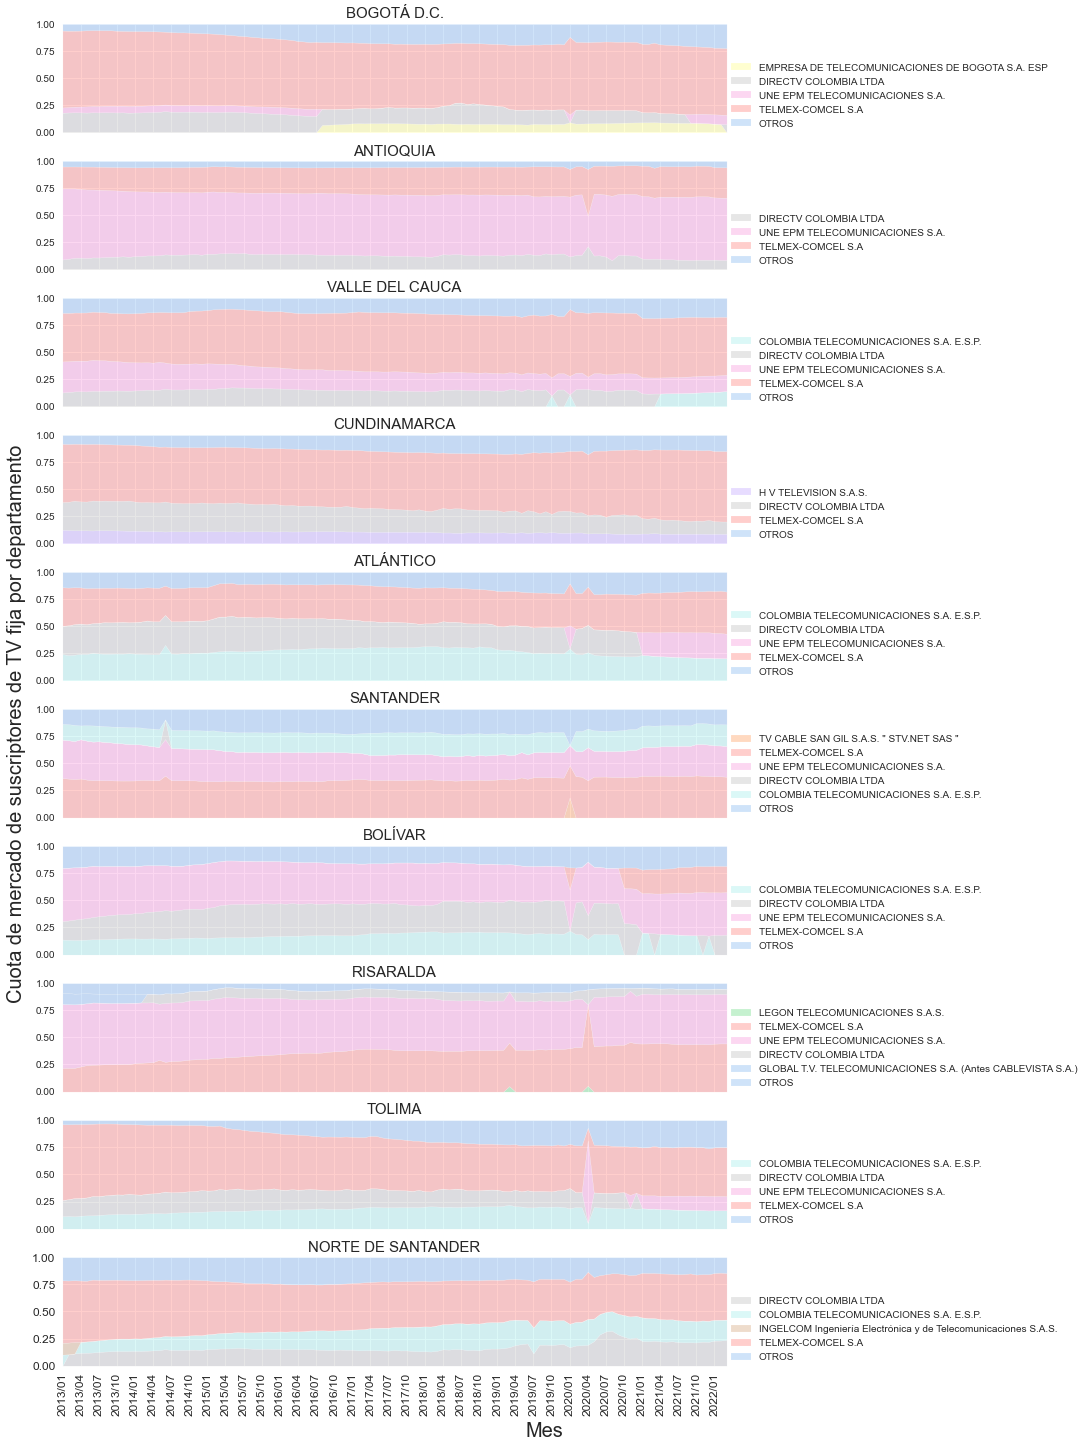

In [348]:
allops=list(set(sum(list(opsl.values()),[])))
no=len(allops)
colores=list(sns.color_palette('pastel',n_colors=no).as_hex())
conv=dict(zip(allops,colores))
fig=plt.figure(figsize=(15,20),facecolor="white",constrained_layout=True)
axs=fig.subplots(nrows=10, sharex=True,sharey=True)
x=np.array(dates)
for i in range(10):
    dept=maindeptos[i]
    color_d=[conv[op] for op in opsl[dept]]
    axs[i].stackplot(x,suscpropl[dept].transpose(),labels=opsl[dept],alpha=0.5,baseline="zero",colors=color_d)
    axs[i].set_title(dept,fontsize=15)
    axs[i].margins(0)
    axs[i].legend(loc=(1,0))
nx=len(x)
bsl=np.linspace(0,nx-1,num=nx).astype(int)
pos=np.arange(0,nx,3)
plt.xticks(ticks=bsl[pos],labels=x[pos],rotation='vertical',fontsize=12)
plt.yticks(ticks=[0,0.25, 0.5,0.75, 1],fontsize=12)
fig.supxlabel("Mes",fontsize=20)
fig.supylabel("Cuota de mercado de suscriptores de TV fija por departamento",fontsize=20)
fig.savefig("grafs/tv_cuotamercado_bydepto.png",dpi=200,facecolor="white")
plt.show()

Miremos en la última fecha (marzo de 2022) cuál era la proporción de suscriptores por departamento.

In [349]:
ultimo=suscprop[suscprop.datetime==dates[-1]].sort_values(by="total",ascending=False)
ultimo["Proporción"]=ultimo.total/ultimo.total.sum()
print("En el mes {1}, los diez departamentos con más proporción tienen el {0:.2f}% del total".format(ultimo.Proporción[:10].sum()*100,dates[-1]))
ultimo[["depto","Proporción"]]

En el mes 2022/03, los diez departamentos con más proporción tienen el 80.59% del total


,depto,Proporción
0,BOGOTÁ D.C.,0.238652
0,ANTIOQUIA,0.192352
0,VALLE DEL CAUCA,0.105141
0,CUNDINAMARCA,0.068662
0,ATLÁNTICO,0.051025
0,SANTANDER,0.046046
0,BOLÍVAR,0.031671
0,RISARALDA,0.026525
0,TOLIMA,0.023752
0,NORTE DE SANTANDER,0.022031


# 2. Evolución de cuota de mercado de internet fija para cada empresa y departamento

El análisis que viene a continuación es muy similar al de televisión pero se enfoca en los accesos a internet. Por eso no se explicará tanto el código porque los pasos son muy similares a los anteriores. Veamos como se ve la tabla de datos inicial.

In [350]:
dirsuscp="https://raw.githubusercontent.com/caramirezs/DataJam2022/master/bases_datos/suscriptores_internet_dpto_empresa.csv"
#dirsuscp="/bases_datos/suscriptores_internet_dpto_empresa.csv" # para importación local
tab=pd.read_csv(dirsuscp)
tab.head()

,datetime,departamento,empresa,accesos
0,2017/02,AMAZONAS,AXESAT S.A.,54
1,2017/02,AMAZONAS,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,341
2,2017/02,AMAZONAS,IFX NETWORKS COLOMBIA S.A.S.,4
3,2017/02,AMAZONAS,SKYNET DE COLOMBIA S.A.S. E.S.P,22
4,2017/02,AMAZONAS,TELECOMMUNICATIONS ADVANCE GROUP S.A.S.,1


Seguimos con tabla de operadores principales.

In [351]:
dates=list(tab.datetime.unique()) #Todas las fechas distintas
deptos=list(tab.departamento.unique()) #Todos los departamentos distintos
cnms=["datetime","depto","op1","op2","op3","prop1","prop2","prop3","prop4","total"]
suscprop = pd.DataFrame(columns = cnms)
for fecha in dates:
    for dept in deptos:
        subtab=tab[(tab.datetime==fecha)&(tab.departamento==dept)].sort_values(by=["accesos"],ascending=False).reset_index(drop=True)
        total=subtab.accesos.sum()
        ns=len(subtab)
        ll=[fecha,dept]+["No hay"]*3+[0]*5
        # Si el número de empresas de datos es menor que 3 y mayor que cero
        if (ns<3 and ns>0):
            ll[2:(2+ns)]=list(subtab.empresa)
            cuota=np.array(subtab.accesos/total)
            resto=1-cuota.sum()
            ll[5:(2+ns)]=list(cuota)
            ll=ll[:10]
        # Si el número de empresas de datos es mayor o igual que 3
        elif (ns>=3 and ns>0):
            ll[2:5]=list(subtab.empresa[:3])
            cuota=np.array(subtab.accesos[:3]/total)
            resto=1-cuota.sum()
            ll[5:8]=list(cuota)
            ll[8]=resto
        ll[9]=total
        lldf=pd.DataFrame([ll],columns=cnms)

        suscprop=pd.concat([suscprop,lldf],axis=0)
suscprop.to_csv("bases_datos/internet_cuotas_dept.csv") # Se guarda la base de datos de cuotas en un CSV
suscprop.head()

,datetime,depto,op1,op2,op3,prop1,prop2,prop3,prop4,total
0,2017/02,AMAZONAS,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,AXESAT S.A.,SKYNET DE COLOMBIA S.A.S. E.S.P,0.808057,0.127962,0.052133,0.011848,422
0,2017/02,ANTIOQUIA,UNE EPM TELECOMUNICACIONES S.A.,TELMEX COLOMBIA S.A.,EDATEL S.A.,0.622874,0.231500,0.122630,0.022996,1074066
0,2017/02,ARAUCA,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,DIRECTV COLOMBIA LTDA,AZTECA COMUNICACIONES COLOMBIA S.A.S,0.653863,0.152456,0.139905,0.053776,9242
0,2017/02,"ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANT...",COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,SOL CABLE VISION S. A. S. - E. S. P.,AZTECA COMUNICACIONES COLOMBIA S.A.S,0.374675,0.313725,0.286794,0.024805,4233
0,2017/02,ATLÁNTICO,METROTEL S.A,TELMEX COLOMBIA S.A.,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,0.382792,0.267258,0.199028,0.150922,314991


Se organiza para gráfica.

In [352]:
maindeptos=list(suscprop[suscprop.datetime==dates[-1]].sort_values(by="total",ascending=False)[:10].depto)
opsl={}
suscpropl={}
dfpl={}
for dept in maindeptos:
    sub=suscprop[suscprop.depto==dept]
    ops=list(sub.op1.unique())+list(sub.op2.unique())+list(sub.op3.unique())
    ops=list(set(ops))
    dfop=pd.DataFrame(dates)
    opsl[dept]=ops
    for op in ops:
        y=[]
        for fecha in dates:
            val=0
            subb=sub[(sub.datetime==fecha) & (sub.op1==op)]
            if len(subb)>0:val=subb.prop1[0]
            subb=sub[(sub.datetime==fecha) & (sub.op2==op)]
            if len(subb)>0:val=subb.prop2[0]
            subb=sub[(sub.datetime==fecha) & (sub.op3==op)]
            if len(subb)>0:val=subb.prop3[0]
            y.append(val)
        dfop[op]=y
    dfop["otros"]=(1-dfop[ops].sum(axis=1))
    opsl[dept]=ops+["OTROS"]
    dfpl[dept]=dfop
    suscpropl[dept]=np.array(dfop[dfop.columns[1:]])


Se hace la gráfica.

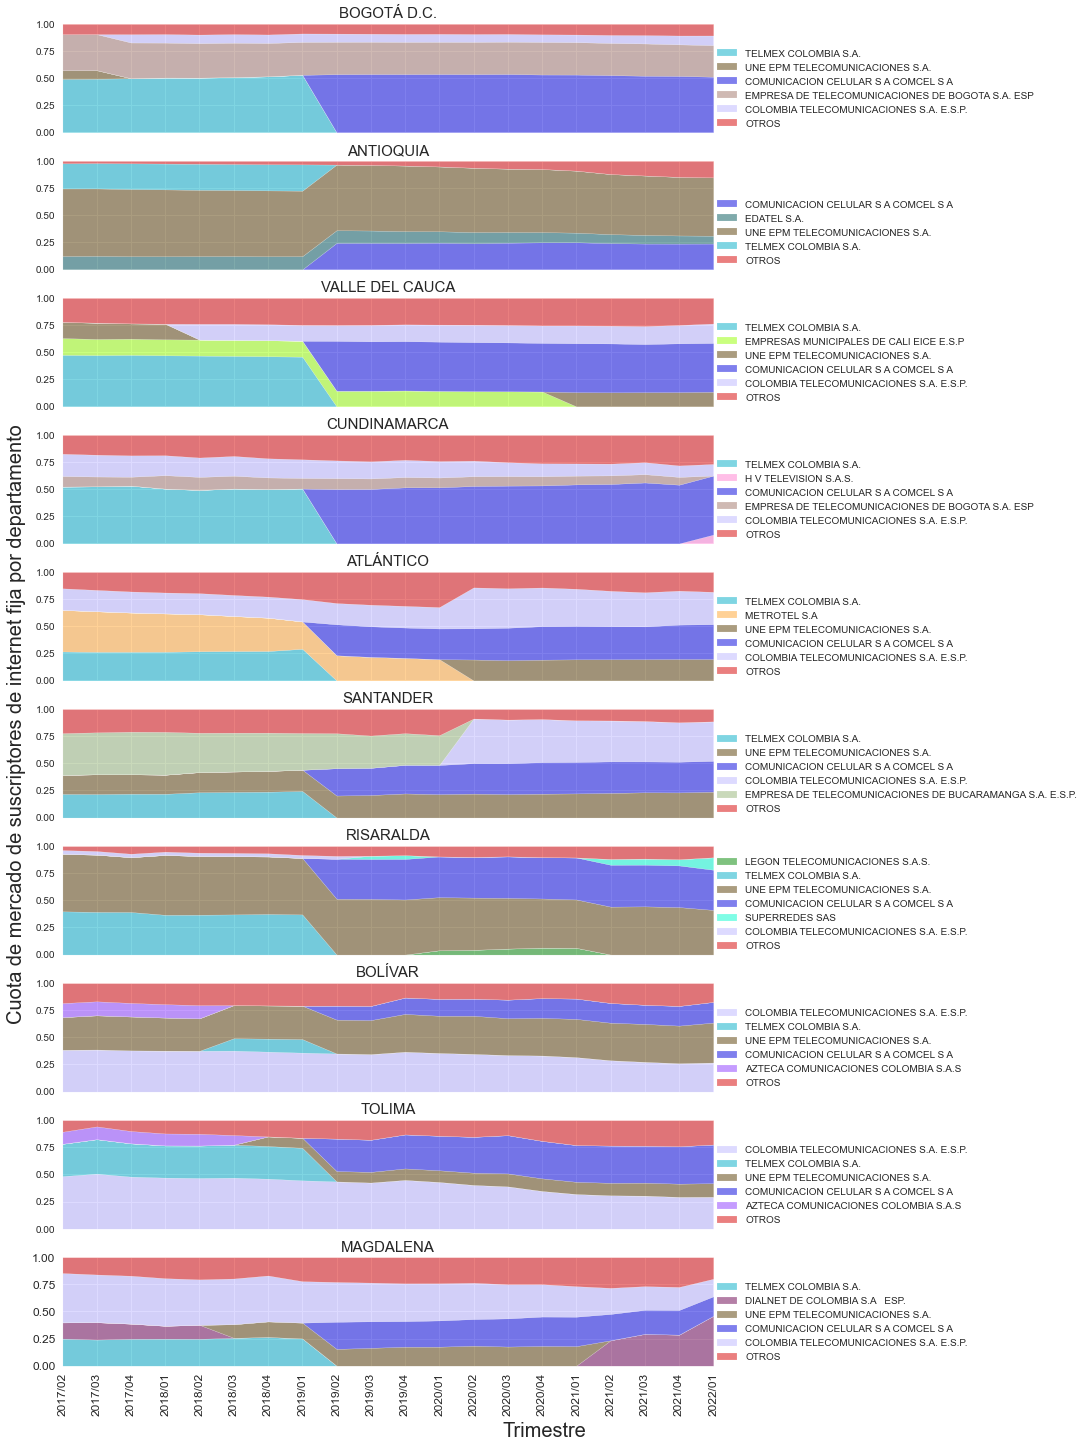

In [353]:
allops=list(set(sum(list(opsl.values()),[])))
no=len(allops)
colores=list(sns.color_palette(cc.b_glasbey_bw_minc_20,n_colors=no).as_hex())
conv=dict(zip(allops,colores))
fig=plt.figure(figsize=(15,20),facecolor="white",constrained_layout=True)
axs=fig.subplots(nrows=10, sharex=True,sharey=True)
x=np.array(dates)
for i in range(10):
    dept=maindeptos[i]
    color_d=[conv[op] for op in opsl[dept]]
    axs[i].stackplot(x,suscpropl[dept].transpose(),labels=opsl[dept],alpha=0.5,baseline="zero",colors=color_d)
    axs[i].set_title(dept,fontsize=15)
    axs[i].margins(0)
    axs[i].legend(loc=(1,0))
nx=len(x)
bsl=np.linspace(0,nx-1,num=nx).astype(int)
pos=np.arange(0,nx,1)
plt.xticks(ticks=bsl[pos],labels=x[pos],rotation='vertical',fontsize=12)
plt.yticks(ticks=[0,0.25, 0.5,0.75, 1],fontsize=12)
fig.supxlabel("Trimestre",fontsize=20)
fig.supylabel("Cuota de mercado de suscriptores de internet fija por departamento",fontsize=20)
fig.savefig("grafs/internet_cuotamercado_bydepto.png",dpi=200,facecolor="white")
plt.show()

Se evalúa le predominancia de los 10 departamentos con más clientes.

In [354]:
ultimo=suscprop[suscprop.datetime==dates[-1]].sort_values(by="total",ascending=False)
ultimo["Proporción"]=ultimo.total/ultimo.total.sum()
print("En el trimestre {1}, los diez departamentos con más proporción tienen el {0:.2f}% del total".format(ultimo.Proporción[:10].sum()*100,dates[-1]))
ultimo[["depto","Proporción"]]

En el trimestre 2022/01, los diez departamentos con más proporción tienen el 80.99% del total


,depto,Proporción
0,BOGOTÁ D.C.,0.258392
0,ANTIOQUIA,0.180482
0,VALLE DEL CAUCA,0.104095
0,CUNDINAMARCA,0.06749
0,ATLÁNTICO,0.051427
0,SANTANDER,0.047999
0,RISARALDA,0.027489
0,BOLÍVAR,0.026832
0,TOLIMA,0.023158
0,MAGDALENA,0.022492


# 3. Cuota de mercado para líneas de telefonía fija

En este caso se genera el archivo de la lista de suscriptores primero y se graba.

In [187]:
dirsuscp="https://raw.githubusercontent.com/caramirezs/DataJam2022/master/bases_datos/telefonia_local_p1.csv"
#dirsuscp="/bases_datos/telefonia_local_p1.csv" # para importación local
tab=pd.read_csv(dirsuscp,low_memory=False)
tab['datetime']=  tab.apply(lambda row: f'{row.anno}/{str(row.trimestre).zfill(2)}', axis=1)
def reempl(x):
    y=x
    if(x=='BOGOTÁ, D.C.'):y='BOGOTÁ D.C.'
    if(x=="CAQUETA"):y="CAQUETÁ"
    if(x=='TELMEX TELECOMUNICACIONES S.A. ESP'):y='TELMEX-COMCEL S.A.'
    if(x=='TELMEX COLOMBIA S.A.'):y='TELMEX-COMCEL S.A.'
    if(x=='COMUNICACION CELULAR S A COMCEL S A'):y='TELMEX-COMCEL S.A.'
    return y
tab=tab.applymap(reempl) #Se tuvo que hacer una pequeña limpieza de nombres de departamento
tab=tab.groupby(['datetime','departamento','empresa'],as_index=False)["lineas"].sum()
tab.to_csv('./bases_datos/lineastelefonicas_dpto_operador.csv')
tab.head()

,datetime,departamento,empresa,lineas
0,2012/01,AMAZONAS,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,2596
1,2012/01,ANTIOQUIA,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,1627
2,2012/01,ANTIOQUIA,EDATEL S.A.,136592
3,2012/01,ANTIOQUIA,TELMEX-COMCEL S.A.,75954
4,2012/01,ANTIOQUIA,UNE EPM TELECOMUNICACIONES S.A.,1339951


De aquí en adelante el análisis es igual excepto en una celda. Lectura de datos.

In [278]:
dirsuscp="https://raw.githubusercontent.com/caramirezs/DataJam2022/master/bases_datos/lineastelefonicas_dpto_operador.csv"
#dirsuscp="/bases_datos/lineastelefonicas_dpto_operador.csv" # para importación local
tab=pd.read_csv(dirsuscp)
tab.head()

,Unnamed: 0,datetime,departamento,empresa,lineas
0,0,2012/01,AMAZONAS,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,2596
1,1,2012/01,ANTIOQUIA,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,1627
2,2,2012/01,ANTIOQUIA,EDATEL S.A.,136592
3,3,2012/01,ANTIOQUIA,TELMEX-COMCEL S.A.,75954
4,4,2012/01,ANTIOQUIA,UNE EPM TELECOMUNICACIONES S.A.,1339951


Elaboración de cuotas.

In [288]:
dates=list(tab.datetime.unique()) #Todas las fechas distintas
deptos=list(tab.departamento.unique()) #Todos los departamentos distintos
cnms=["datetime","depto","op1","op2","op3","prop1","prop2","prop3","prop4","total"]
suscprop = pd.DataFrame(columns = cnms)
for fecha in dates:
    for dept in deptos:
        subtab=tab[(tab.datetime==fecha)&(tab.departamento==dept)].sort_values(by=["lineas"],ascending=False).reset_index(drop=True)
        total=subtab.lineas.sum()
        ns=len(subtab)
        ll=[fecha,dept]+["No hay"]*3+[0]*5
        # Si el número de empresas de datos es menor que 3 y mayor que cero
        if (ns<3 and ns>0):
            ll[2:(2+ns)]=list(subtab.empresa)
            cuota=np.array(subtab.lineas/total)
            resto=1-cuota.sum()
            ll[5:(2+ns)]=list(cuota)
            ll=ll[:10]
        # Si el número de empresas de datos es mayor o igual que 3
        elif (ns>=3 and ns>0):
            ll[2:5]=list(subtab.empresa[:3])
            cuota=np.array(subtab.lineas[:3]/total)
            resto=1-cuota.sum()
            ll[5:8]=list(cuota)
            ll[8]=resto
        ll[9]=total
        lldf=pd.DataFrame([ll],columns=cnms)

        suscprop=pd.concat([suscprop,lldf],axis=0)
suscprop.to_csv("bases_datos/telefonia_cuotas_dept.csv") # Se guarda la base de datos de cuotas en un CSV
suscprop.head()

,datetime,depto,op1,op2,op3,prop1,prop2,prop3,prop4,total
0,2012/01,AMAZONAS,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,No hay,No hay,1.000000,0,0,0,2596
0,2012/01,ANTIOQUIA,UNE EPM TELECOMUNICACIONES S.A.,EDATEL S.A.,TELMEX-COMCEL S.A.,0.862191,0.08789,0.048873,0.001047,1554124
0,2012/01,ARAUCA,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,No hay,No hay,1.000000,0,0,0,13614
0,2012/01,"ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANT...",COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,No hay,No hay,1.000000,0,0,0,9677
0,2012/01,ATLÁNTICO,METROPOLITANA DE TELECOMUNICACIONES S.A. E.S.P...,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,TELMEX-COMCEL S.A.,0.479134,0.350418,0.148903,0.021545,265172


Preparación para la gráfica. En algunos departamentos principales hay menos de dos operadores en algunas fechas. Por eso se modificaron un par de líneas.

In [326]:
maindeptos=list(suscprop[suscprop.datetime==dates[-1]].sort_values(by="total",ascending=False)[:10].depto)
opsl={}
suscpropl={}
dfpl={}
for dept in maindeptos:
    sub=suscprop[suscprop.depto==dept]
    ops=list(sub.op1.unique())+list(sub.op2.unique())+list(sub.op3.unique())
    ops=list(set(ops))
    dfop=pd.DataFrame(dates)
    opsl[dept]=ops
    for op in ops:
        y=[]
        for fecha in dates:
            val=0
            subb=sub[(sub.datetime==fecha) & (sub.op1==op)]
            if len(subb)>0:val=subb.prop1[0]
            subb=sub[(sub.datetime==fecha) & (sub.op2==op)]
            if len(subb)>0:val=subb.prop2[0]
            subb=sub[(sub.datetime==fecha) & (sub.op3==op)]
            if len(subb)>0:val=subb.prop3[0]
            y.append(val)
        dfop[op]=y
    dfop["OTROS"]=(1-dfop[ops].sum(axis=1))
    if "No hay" in dfop.columns:dfop=dfop.drop(["No hay"],axis=1) # linea extra por si hay menos de 3 operadores
    opsl[dept]=list(dfop.columns[1:]) #modificación por la línea anterior
    dfpl[dept]=dfop
    suscpropl[dept]=np.array(dfop[dfop.columns[1:]])


Gráfica.

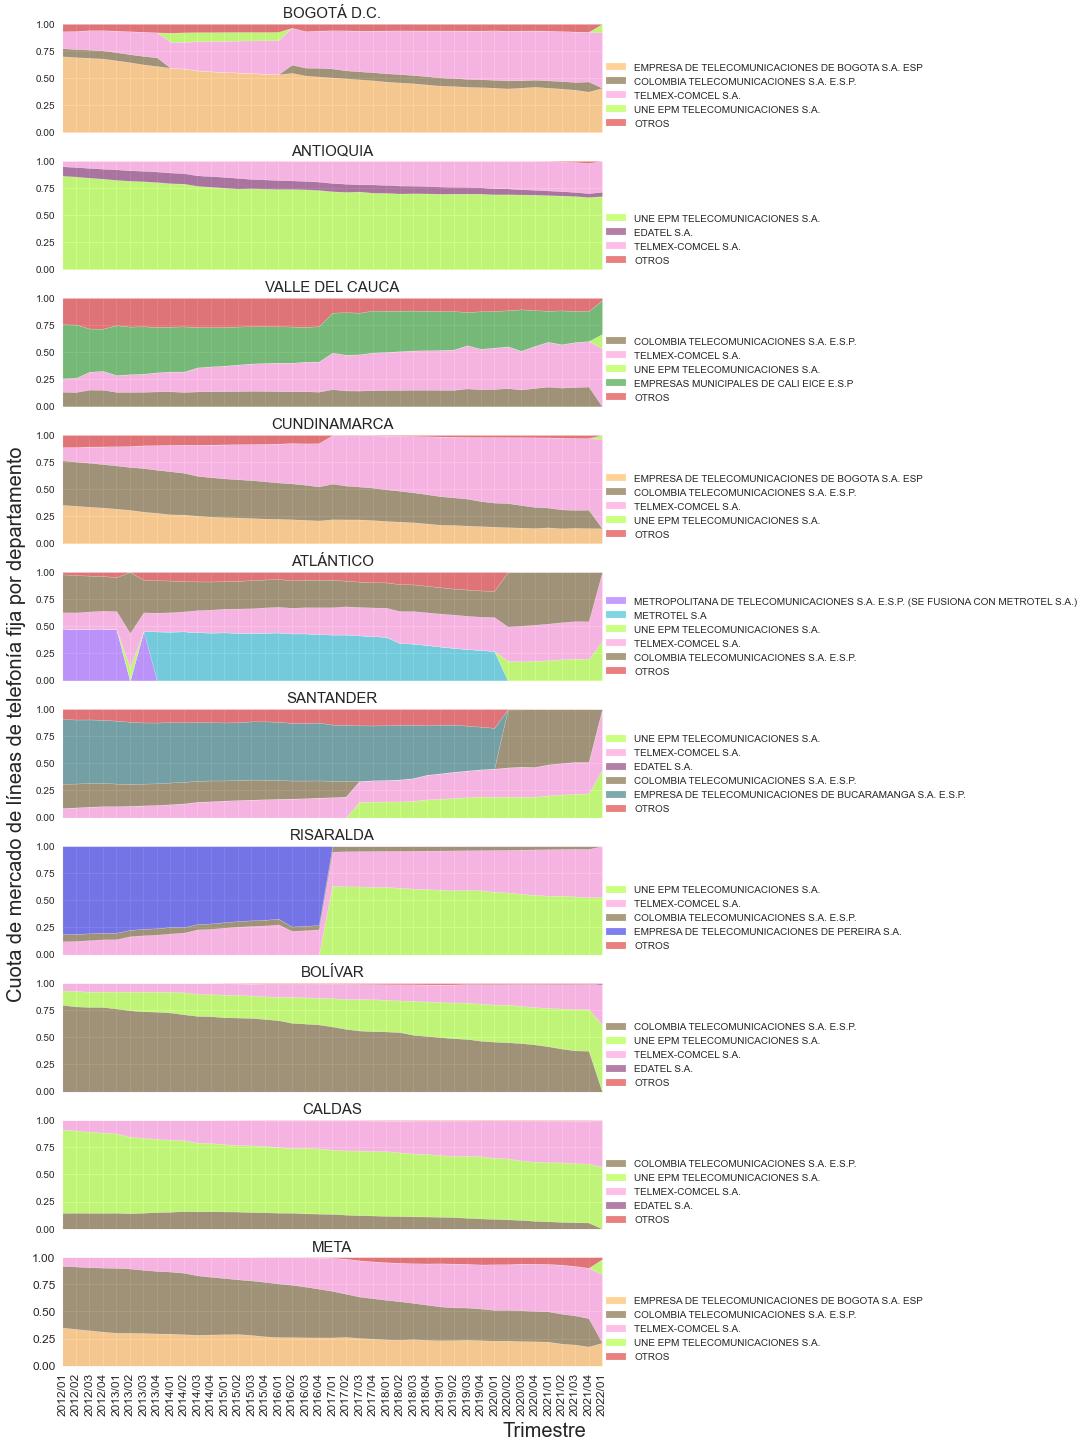

In [327]:
allops=list(set(sum(list(opsl.values()),[])))
no=len(allops)
colores=list(sns.color_palette(cc.b_glasbey_bw_minc_20,n_colors=no).as_hex())
conv=dict(zip(allops,colores))
fig=plt.figure(figsize=(15,20),facecolor="white",constrained_layout=True)
axs=fig.subplots(nrows=10, sharex=True,sharey=True)
x=np.array(dates)
for i in range(10):
    dept=maindeptos[i]
    color_d=[conv[op] for op in opsl[dept]]
    axs[i].stackplot(x,suscpropl[dept].transpose(),alpha=0.5,labels=opsl[dept],baseline="zero",colors=color_d)
    axs[i].set_title(dept,fontsize=15)
    axs[i].margins(0)
    axs[i].legend(loc=(1,0))
nx=len(x)
bsl=np.linspace(0,nx-1,num=nx).astype(int)
pos=np.arange(0,nx,1)
plt.xticks(ticks=bsl[pos],labels=x[pos],rotation='vertical',fontsize=12)
plt.yticks(ticks=[0,0.25, 0.5,0.75, 1],fontsize=12)
fig.supxlabel("Trimestre",fontsize=20)
fig.supylabel("Cuota de mercado de líneas de telefonía fija por departamento",fontsize=20)
fig.savefig("grafs/telefonia_cuotamercado_bydepto.png",dpi=200,facecolor="white")
plt.show()

Predominio de los primeros diez departamentos. Es posible que en la última fecha falten de datos por eso se escoge una anterior.

In [338]:
ultimo=suscprop[suscprop.datetime==dates[-4]].sort_values(by="total",ascending=False)
ultimo["Proporción"]=ultimo.total/ultimo.total.sum()
print("En el trimestre {1} los diez departamentos con más proporción tienen el {0:.2f}% del total.".format(ultimo.Proporción[:10].sum()*100,dates[-4]))
ultimo[["depto","Proporción"]]

En el trimestre 2021/02 los diez departamentos con más proporción tienen el 86.53% del total.


,depto,Proporción
0,BOGOTÁ D.C.,0.32791
0,ANTIOQUIA,0.173457
0,VALLE DEL CAUCA,0.120951
0,CUNDINAMARCA,0.053548
0,SANTANDER,0.053181
0,ATLÁNTICO,0.049585
0,BOLÍVAR,0.024547
0,RISARALDA,0.023185
0,NORTE DE SANTANDER,0.02143
0,TOLIMA,0.017528
